# Laydown Planner - Optimization
Optimizes object placement using 2D bin packing with category-based nesting and stacking.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
import ezdxf
import os

print('All imports successful!')

All imports successful!


## 2. Load Data

In [2]:
objects_df = pd.read_csv('../data/sample_objects.csv')

print(f'Loaded {len(objects_df)} object types')
print(f'\nCategories:')
print(objects_df['category'].value_counts())
print(f'\nStackable objects:')
print(objects_df[objects_df['stackable'] == True][['name', 'stackable', 'max_stack_height']])

Loaded 50 object types

Categories:
category
Category 1    19
Category 2    16
Category 3    15
Name: count, dtype: int64

Stackable objects:
         name  stackable  max_stack_height
0    Object A       True                10
1    Object B       True                 8
3    Object D       True                12
5    Object F       True                15
6    Object G       True                 9
8    Object I       True                11
10   Object K       True                13
11   Object L       True                 6
12   Object M       True                 8
14   Object O       True                10
15   Object P       True                 9
17   Object R       True                 8
19   Object T       True                 5
20   Object U       True                15
22   Object W       True                14
23   Object X       True                13
25   Object Z       True                12
26  Object AA       True                11
27  Object AB       True                1

## 3. Define 2D Bin Packing Classes

In [26]:
class Bin:
    def __init__(self, width, length, bin_id, min_spacing=0):
        self.width = width
        self.length = length
        self.bin_id = bin_id
        self.rectangles = []
        self.min_spacing = min_spacing
    
    def can_fit(self, rect):
        for existing in self.rectangles:
            if self._overlaps(rect, existing):
                return False
        
        # Check if rect fits in bin with spacing
        if rect.x + rect.get_width() + self.min_spacing > self.width:
            return False
        if rect.y + rect.get_length() + self.min_spacing > self.length:
            return False
        
        return True
    
    def _overlaps(self, rect1, rect2):
        # Include spacing in overlap detection
        return not (rect1.x + rect1.get_width() + self.min_spacing <= rect2.x or 
                   rect1.x >= rect2.x + rect2.get_width() + self.min_spacing or
                   rect1.y + rect1.get_length() + self.min_spacing <= rect2.y or 
                   rect1.y >= rect2.y + rect2.get_length() + self.min_spacing)
    
    def add_rectangle(self, rect):
        if self.can_fit(rect):
            self.rectangles.append(rect)
            return True
        return False
    
    def find_position(self, rect):
        positions = [(0, 0)]
        
        for existing in self.rectangles:
            positions.append((existing.x + existing.get_width() + self.min_spacing, existing.y))
            positions.append((existing.x, existing.y + existing.get_length() + self.min_spacing))
        
        for x, y in sorted(positions):
            rect.x = x
            rect.y = y
            rect.rotated = False
            
            if self.can_fit(rect):
                return True
            
            rect.rotated = True
            if self.can_fit(rect):
                return True
            
            rect.rotated = False
        
        return False

## 4. Implement Packing Algorithm

In [39]:
def pack_objects(objects_df, bin_width=100, bin_length=100, min_spacing=0):
    """
    Pack objects by category into bins using 2D bin packing with minimum spacing.
    """
    categories = objects_df['category'].unique()
    all_bins = []
    
    for category in categories:
        category_df = objects_df[objects_df['category'] == category]
        print(f"\nProcessing category: {category} ({len(category_df)} objects)")
        
        # Create rectangles for this category
        rects = []
        for _, row in category_df.iterrows():
            rect = Rectangle(
                width=float(row['width']),
                length=float(row['length']),
                obj_id=row['object_id'],
                obj_name=row['name'],
                category=row['category'],
                weight=float(row['weight']),
                stackable=row['stackable'] in [True, 'True', 'TRUE'],
                max_stack=int(row['max_stack_height'])
            )
            rects.append(rect)
        
        # Sort by area (largest first)
        rects.sort(key=lambda r: r.area(), reverse=True)
        
        # Pack into bins
        bins = []
        
        for rect in rects:
            placed = False
            
            # Try to stack on existing object of same type
            if rect.stackable:
                for bin_obj in bins:
                    for existing in bin_obj.rectangles:
                        if (existing.obj_id == rect.obj_id and 
                            existing.stack_height < existing.max_stack):
                            # Stack on top
                            rect.x = existing.x
                            rect.y = existing.y
                            rect.stack_height = existing.stack_height + 1
                            existing.stack_height = rect.stack_height
                            bin_obj.rectangles.append(rect)
                            placed = True
                            print(f"    Stacked: {rect.obj_name} (stack height: {rect.stack_height})")
                            break
                    if placed:
                        break
            
            # If not stacked, try to fit in existing bin
            if not placed:
                for bin_obj in bins:
                    # Try different positions (bottom-left heuristic)
                    positions_to_try = [(0, 0)]
                    
                    # Add positions next to existing rectangles
                    for existing in bin_obj.rectangles:
                        positions_to_try.append((existing.x + existing.get_width() + min_spacing, existing.y))
                        positions_to_try.append((existing.x, existing.y + existing.get_length() + min_spacing))
                    
                    for x, y in positions_to_try:
                        # Try normal orientation
                        rect.x = x
                        rect.y = y
                        rect.rotated = False
                        
                        # Check if fits with spacing
                        fits = True
                        if rect.x + rect.get_width() + min_spacing > bin_obj.width:
                            fits = False
                        if rect.y + rect.get_length() + min_spacing > bin_obj.length:
                            fits = False
                        
                        # Check overlap with existing rectangles
                        if fits:
                            for existing in bin_obj.rectangles:
                                if bin_obj._overlaps(rect, existing):
                                    fits = False
                                    break
                        
                        if fits:
                            bin_obj.rectangles.append(rect)
                            placed = True
                            print(f"    Placed: {rect.obj_name} at ({x}, {y})")
                            break
                        
                        # Try rotated orientation
                        rect.rotated = True
                        fits = True
                        if rect.x + rect.get_width() + min_spacing > bin_obj.width:
                            fits = False
                        if rect.y + rect.get_length() + min_spacing > bin_obj.length:
                            fits = False
                        
                        if fits:
                            for existing in bin_obj.rectangles:
                                if bin_obj._overlaps(rect, existing):
                                    fits = False
                                    break
                        
                        if fits:
                            bin_obj.rectangles.append(rect)
                            placed = True
                            print(f"    Placed (rotated): {rect.obj_name} at ({x}, {y})")
                            break
                        
                        rect.rotated = False
                    
                    if placed:
                        break
            
            # If doesn't fit in any bin, create new bin
            if not placed:
                new_bin = Bin(bin_width, bin_length, len(bins), min_spacing=min_spacing)
                rect.x = 0
                rect.y = 0
                rect.rotated = False
                
                # Check if fits with spacing
                if (rect.get_width() + min_spacing <= new_bin.width and
                    rect.get_length() + min_spacing <= new_bin.length):
                    new_bin.rectangles.append(rect)
                    bins.append(new_bin)
                    placed = True
                    print(f"    New bin: {rect.obj_name} (normal)")
                else:
                    # Try rotated orientation
                    rect.rotated = True
                    if (rect.get_width() + min_spacing <= new_bin.width and
                        rect.get_length() + min_spacing <= new_bin.length):
                        new_bin.rectangles.append(rect)
                        bins.append(new_bin)
                        placed = True
                        print(f"    New bin: {rect.obj_name} (rotated)")
            
            if not placed:
                print(f"    WARNING: Could not place {rect.obj_name} (w={rect.width}, l={rect.length})")
        
        all_bins.extend(bins)
        print(f"  ✓ Created {len(bins)} bins for category {category}")
    
    return all_bins

print('✓ Packing algorithm defined (v3 - spacing fixed)')

✓ Packing algorithm defined (v3 - spacing fixed)


### Testing..

In [34]:
# First, let's see what dimensions we're working with
print("=== OBJECT DIMENSIONS ===")
print(f"Width - Min: {objects_df['width'].min()}, Max: {objects_df['width'].max()}")
print(f"Length - Min: {objects_df['length'].min()}, Max: {objects_df['length'].max()}")

print(f"\nObject areas:")
objects_df['area'] = objects_df['width'] * objects_df['length']
print(objects_df[['name', 'width', 'length', 'area']].sort_values('area', ascending=False).head(10))

# Calculate appropriate bin size
max_width = objects_df['width'].max()
max_length = objects_df['length'].max()
suggested_bin_width = max_width * 1.5
suggested_bin_length = max_length * 1.5

print(f"\nSuggested bin size: {suggested_bin_width} x {suggested_bin_length}")

=== OBJECT DIMENSIONS ===
Width - Min: 100, Max: 200
Length - Min: 200, Max: 690

Object areas:
         name  width  length    area
49  Object AX    190     690  131100
48  Object AW    180     680  122400
40  Object AO    200     600  120000
47  Object AV    170     670  113900
39  Object AN    190     590  112100
46  Object AU    160     660  105600
38  Object AM    180     580  104400
30  Object AE    200     500  100000
45  Object AT    150     650   97500
37  Object AL    170     570   96900

Suggested bin size: 300.0 x 1035.0


### 4.5 Space between objects

In [29]:
# User input for minimum spacing
spacing_input = input(f"Enter minimum spacing between objects (default 0): ").strip()

try:
    min_spacing = float(spacing_input) if spacing_input else 0
except ValueError:
    print("Invalid input! Using default: 0")
    min_spacing = 0

print(f"✓ Using minimum spacing: {min_spacing}")

✓ Using minimum spacing: 25.0


### 4.9 Affect Bin Size

In [30]:
# User input for bin dimensions
print("=== BIN CONFIGURATION ===")
print(f"Current object dimensions:")
print(f"  Width range: {objects_df['width'].min()} - {objects_df['width'].max()}")
print(f"  Length range: {objects_df['length'].min()} - {objects_df['length'].max()}")

# Get user input
bin_width_input = input(f"Enter bin width (default 350): ").strip()
bin_length_input = input(f"Enter bin length (default 1100): ").strip()

# Parse inputs with defaults
try:
    bin_width = float(bin_width_input) if bin_width_input else 350
    bin_length = float(bin_length_input) if bin_length_input else 1100
except ValueError:
    print("Invalid input! Using defaults: 350 x 1100")
    bin_width = 350
    bin_length = 1100

print(f"\n✓ Using bin size: {bin_width} x {bin_length}")

=== BIN CONFIGURATION ===
Current object dimensions:
  Width range: 100 - 200
  Length range: 200 - 690

✓ Using bin size: 600.0 x 1400.0


## 5. Generate Optimized Laydown Plan

In [40]:
# Pack objects with user-specified bin sizes
bins = pack_objects(objects_df, bin_width=bin_width, bin_length=bin_length, min_spacing=min_spacing)

print(f'\n✓ Packing complete')
print(f'Total bins needed: {len(bins)}')
print(f'Total objects packed: {sum(len(bin.rectangles) for bin in bins)}')

for i, bin_obj in enumerate(bins):
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    print(f'\nBin {i}: {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization')


Processing category: Category 1 (19 objects)
    New bin: Object AW (normal)
    Placed: Object AN at (205.0, 0)
    Placed: Object AT at (0, 705.0)
    Placed: Object AD at (205.0, 615.0)
    New bin: Object AK (normal)
    Placed: Object AR at (420.0, 0)
    Placed: Object AA at (185.0, 0)
    Placed: Object AH at (420.0, 655.0)
    Placed: Object S at (0, 585.0)
    Placed: Object K at (370.0, 0)
    Placed: Object AF at (205.0, 585.0)
    Placed: Object X at (370.0, 325.0)
    Placed: Object P at (0, 990.0)
    Placed (rotated): Object I at (205.0, 1120.0)
    New bin: Object V (normal)
    Placed: Object G at (370.0, 780.0)
    Placed: Object M at (135.0, 0)
    Placed: Object B at (205.0, 1130.0)
    Placed: Object A at (0, 435.0)
  ✓ Created 3 bins for category Category 1

Processing category: Category 2 (16 objects)
    New bin: Object AX (normal)
    Placed: Object AO at (215.0, 0)
    Placed: Object AU at (0, 715.0)
    Placed: Object AE at (215.0, 625.0)
    New bin: Object

## 5.5 Visualize the Plan

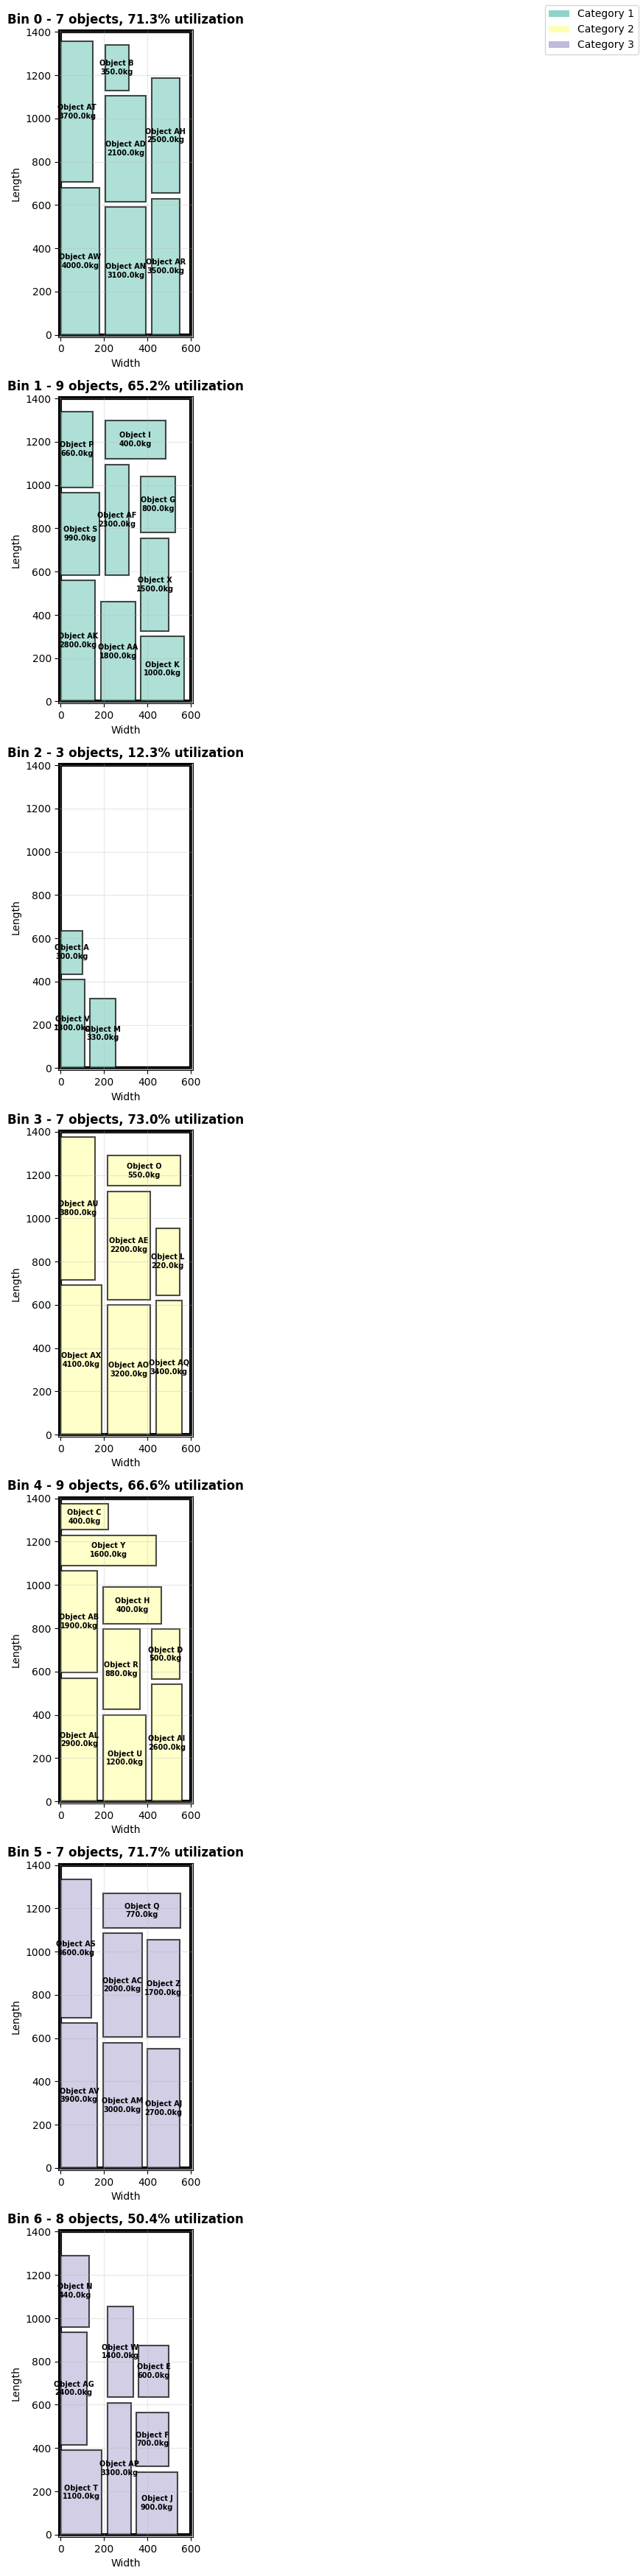

✓ Visualization complete


In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Visualize bins
fig, axes = plt.subplots(len(bins), 1, figsize=(14, 5*len(bins)))

# Handle single bin case
if len(bins) == 1:
    axes = [axes]

# Color map for categories
categories = objects_df['category'].unique()
color_map = {cat: plt.cm.Set3(i) for i, cat in enumerate(categories)}

for bin_idx, bin_obj in enumerate(bins):
    ax = axes[bin_idx]
    
    # Draw bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_obj.width, bin_obj.length, 
                                  linewidth=3, edgecolor='black', facecolor='none')
    ax.add_patch(bin_rect)
    
    # Draw objects
    stack_offset = {}
    for rect in bin_obj.rectangles:
        # Calculate stack offset
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 2
        
        # Get color based on category
        color = color_map.get(rect.category, 'gray')
        
        # Draw rectangle with offset for stacked items
        x = rect.x + offset
        y = rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        obj_rect = patches.Rectangle((x, y), w, l, 
                                     linewidth=1.5, edgecolor='black', 
                                     facecolor=color, alpha=0.7)
        ax.add_patch(obj_rect)
        
        # Add label
        label = f"{rect.obj_name}\n{rect.weight}kg"
        if rect.stack_height > 1:
            label += f"\n(x{rect.stack_height})"
        
        ax.text(x + w/2, y + l/2, label, ha='center', va='center', 
               fontsize=7, fontweight='bold')
    
    # Customize axis
    ax.set_xlim(-10, bin_obj.width + 10)
    ax.set_ylim(-10, bin_obj.length + 10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Width', fontsize=10)
    ax.set_ylabel('Length', fontsize=10)
    
    # Calculate utilization
    total_area = sum(rect.area() for rect in bin_obj.rectangles)
    utilization = (total_area / (bin_obj.width * bin_obj.length)) * 100
    
    ax.set_title(f'Bin {bin_idx} - {len(bin_obj.rectangles)} objects, {utilization:.1f}% utilization', 
                fontsize=12, fontweight='bold')

# Add legend
legend_elements = [patches.Patch(facecolor=color_map[cat], label=cat) 
                  for cat in sorted(categories)]
fig.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print('✓ Visualization complete')

In [7]:
print("=== DEBUGGING PACKING ===")
print(f"\nObjects DataFrame shape: {objects_df.shape}")
print(f"Objects DataFrame columns: {objects_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(objects_df.head())

print(f"\nData types:")
print(objects_df.dtypes)

print(f"\nUnique categories: {objects_df['category'].unique()}")
print(f"Number of categories: {objects_df['category'].nunique()}")

# Check for NaN values
print(f"\nMissing values:")
print(objects_df.isnull().sum())

# Try packing with verbose output
print("\n=== ATTEMPTING PACK ===")
try:
    bins = pack_objects(objects_df, bin_width=100, bin_length=100)
    print(f"Packing successful! Created {len(bins)} bins")
    for i, bin_obj in enumerate(bins):
        print(f"  Bin {i}: {len(bin_obj.rectangles)} objects")
except Exception as e:
    print(f"Packing failed: {e}")
    import traceback
    traceback.print_exc()

=== DEBUGGING PACKING ===

Objects DataFrame shape: (50, 9)
Objects DataFrame columns: ['object_id', 'name', 'category', 'width', 'length', 'height', 'weight', 'stackable', 'max_stack_height']

First few rows:
   object_id      name    category  width  length  height  weight  stackable  \
0          1  Object A  Category 1    100     200     150     300       True   
1          2  Object B  Category 1    110     210     160     350       True   
2          3  Object C  Category 2    120     220     170     400      False   
3          4  Object D  Category 2    130     230     175     500       True   
4          5  Object E  Category 3    140     240     180     600      False   

   max_stack_height  
0                10  
1                 8  
2                 0  
3                12  
4                 0  

Data types:
object_id           int64
name                  str
category              str
width               int64
length              int64
height              int64
weight  

## 6. Generate DXF from Optimized Plan

In [42]:
doc = ezdxf.new()
msp = doc.modelspace()

y_offset = 0
for bin_idx, bin_obj in enumerate(bins):
    bin_x = 0
    bin_y = y_offset
    
    msp.add_lwpolyline([
        (bin_x, bin_y), 
        (bin_x + bin_obj.width, bin_y), 
        (bin_x + bin_obj.width, bin_y + bin_obj.length), 
        (bin_x, bin_y + bin_obj.length), 
        (bin_x, bin_y)
    ], close=True)
    
    stack_offset = {}
    for rect in bin_obj.rectangles:
        key = (rect.x, rect.y)
        if key not in stack_offset:
            stack_offset[key] = 0
        offset = stack_offset[key]
        stack_offset[key] += 0.5
        
        x = bin_x + rect.x + offset
        y = bin_y + rect.y + offset
        w = rect.get_width()
        l = rect.get_length()
        
        msp.add_lwpolyline([
            (x, y), 
            (x + w, y), 
            (x + w, y + l), 
            (x, y + l), 
            (x, y)
        ], close=True)
        
        label = f"{rect.obj_name} {rect.weight}kg"
        if rect.stack_height > 1:
            label += f" (x{rect.stack_height})"
        
        msp.add_text(label, dxfattribs={
            'insert': (x + w/2, y + l/2),
            'height': 1,
            'halign': 1,
        })
    
    y_offset += bin_obj.length + 5

os.makedirs('../data', exist_ok=True)
doc.saveas('../data/optimized_laydown.dxf')

print('✓ DXF generated: data/optimized_laydown.dxf')

✓ DXF generated: data/optimized_laydown.dxf


## 7. Summary

In [43]:
print('=== OPTIMIZATION SUMMARY ===')
print(f'Total objects: {len(objects_df)}')
print(f'Total bins created: {len(bins)}')
print(f'\nBin Details:')
for i, bin_obj in enumerate(bins):
    stacked = sum(1 for rect in bin_obj.rectangles if rect.stack_height > 1)
    print(f'  Bin {i}: {len(bin_obj.rectangles)} items, {stacked} stacks')
print('✓ Optimization complete!')

=== OPTIMIZATION SUMMARY ===
Total objects: 50
Total bins created: 7

Bin Details:
  Bin 0: 7 items, 0 stacks
  Bin 1: 9 items, 0 stacks
  Bin 2: 3 items, 0 stacks
  Bin 3: 7 items, 0 stacks
  Bin 4: 9 items, 0 stacks
  Bin 5: 7 items, 0 stacks
  Bin 6: 8 items, 0 stacks
✓ Optimization complete!
